# 로지스틱 회귀 - 이항분류

## #01. 패키지 준비하기

In [1]:
import sys
sys.path.append('../../')
import helper

from pandas import read_excel, DataFrame
from matplotlib import pyplot as plt
import seaborn as sb
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score, accuracy_score, recall_score, precision_score, f1_score

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import ModelCheckpoint

## #02. 데이터셋 준비하기

방사선학 석사과정 대학원생 모집을 하였다. 이 때 지원한 방사선사의 대학원 합격 여부에 따른 주요 요인이 무엇인지 분석하라.

단, 독립변수는 정규분포를 따른다고 가정한다.

| 변수 | 구분 | 설명 |
|---|---|---
| 합격여부 | 범주형 | 1=합격, 0=불합격 |
| 필기점수 | 연속형 | 800점 만점 |
| 학부성적 | 연속형 | 4.0 만점 |
| 병원경력 | 범주형 | 1: 10년이상, 2: 2~5년, 3: 1~5년, 4: 1년 미만 |

In [2]:
origin = read_excel("https://data.hossam.kr/E05/gradeuate.xlsx")
origin.head()

,합격여부,필기점수,학부성적,병원경력
0,0,380,3.61,3
1,1,660,3.67,3
2,1,800,4.00,1
3,1,640,3.19,4
4,0,520,2.93,4


## #03. 데이터 전처리

### 결측치 확인

In [3]:
origin.isna().sum()

합격여부    0
필기점수    0
학부성적    0
병원경력    0
dtype: int64

### 명목형에 대한 데이터 타입 설정

In [4]:
origin['합격여부'] = origin['합격여부'].astype('category')
origin.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype   
---  ------  --------------  -----   
 0   합격여부    400 non-null    category
 1   필기점수    400 non-null    int64   
 2   학부성적    400 non-null    float64 
 3   병원경력    400 non-null    int64   
dtypes: category(1), float64(1), int64(2)
memory usage: 10.0 KB


## #04. 탐색적 데이터 분석

### 기본통계 확인

In [5]:
origin.describe()

,필기점수,학부성적,병원경력
count,400.000000,400.000000,400.00000
mean,587.700000,3.389900,2.48500
std,115.516536,0.380567,0.94446
min,220.000000,2.260000,1.00000
25%,520.000000,3.130000,2.00000
50%,580.000000,3.395000,2.00000
75%,660.000000,3.670000,3.00000
max,800.000000,4.000000,4.00000


### 상자그림 확인

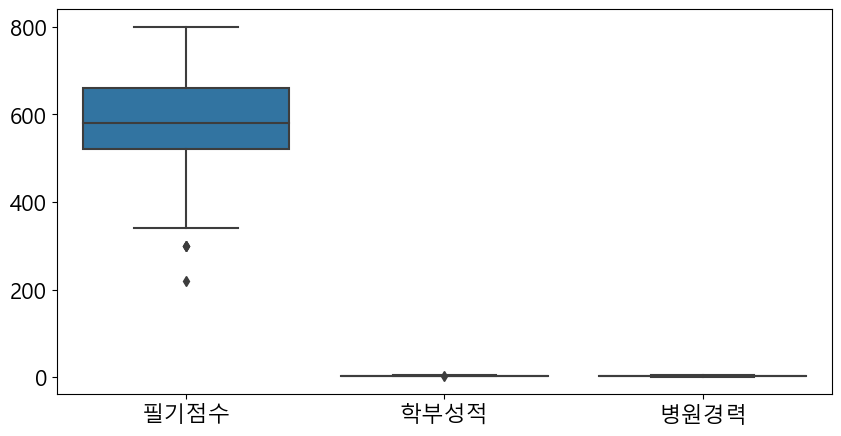

In [6]:
plt.figure(figsize=(10, 5))
sb.boxplot(data=origin)
plt.show()
plt.close()

> 데이터 단위가 크게 다르므로 표준화가 필요해 보임

## #05. 데이터셋 분할하기

### 랜덤시드 고정

In [7]:
np.random.seed(777)

### 훈련 데이터(독립변수)와 레이블(종속변수) 구분하기

In [8]:
x = origin[['필기점수','학부성적','병원경력']]
y = origin[['합격여부']]
x.shape, y.shape

((400, 3), (400, 1))

### 데이터 표준화

In [10]:
x_scaller = StandardScaler()
x_scale = x_scaller.fit_transform(x)
print(x_scale.shape)
x_scale

(400, 3)


array([[-1.80026271,  0.57907192,  0.54596793],
       [ 0.62666824,  0.73692942,  0.54596793],
       [ 1.84013372,  1.60514289, -1.57429586],
       ...,
       [-1.10685387, -1.99925902, -0.51416397],
       [ 0.97337266,  0.68431046, -0.51416397],
       [ 0.10661161,  1.31573861,  0.54596793]])

### 표준화 전 후 상자그림 비교

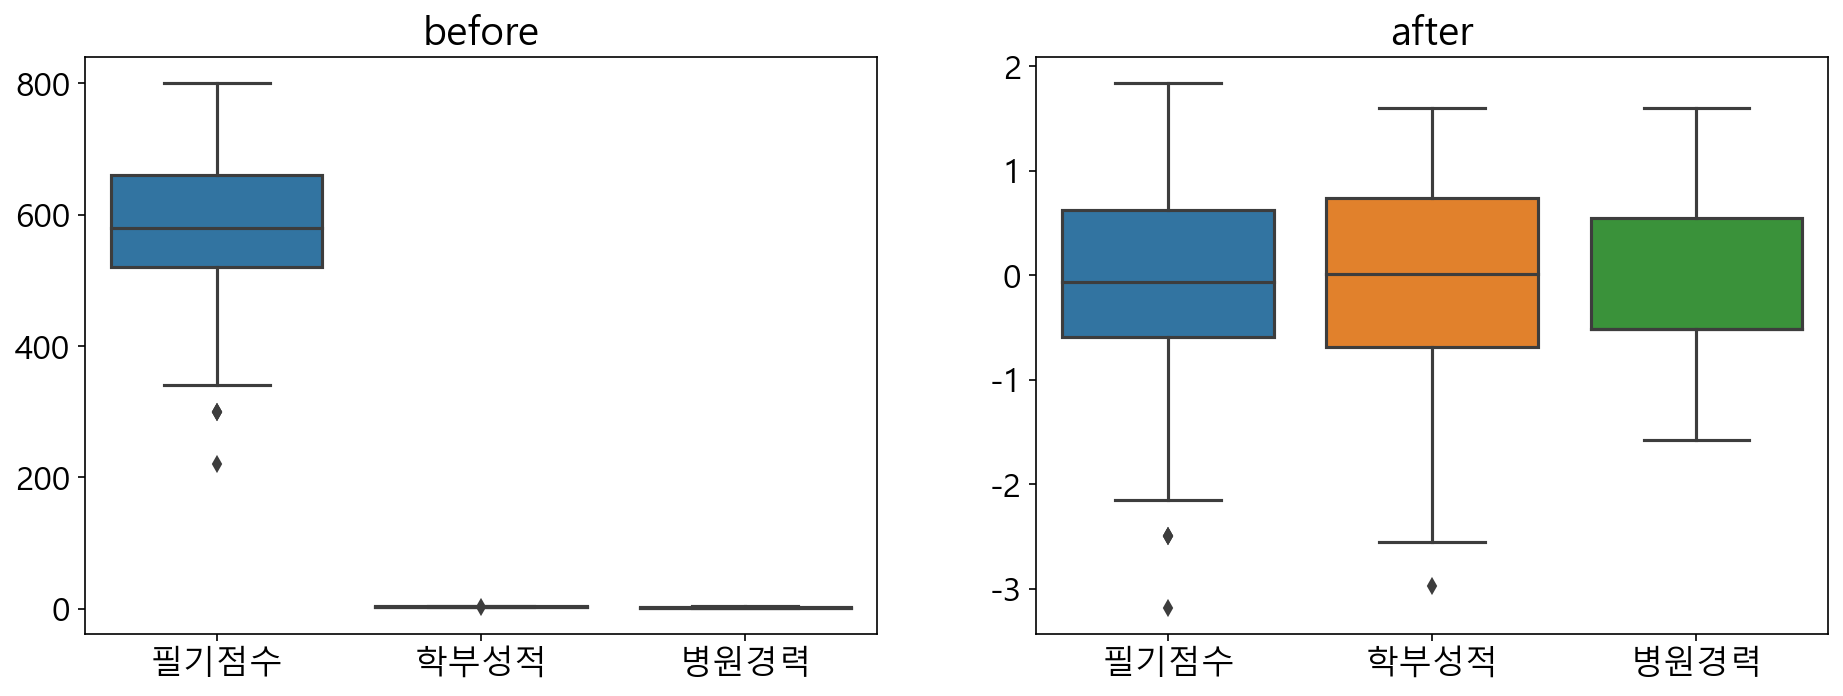

In [11]:
# 임시로 독립변수와 종속변수를 하나의 DataFrame으로 병합
x_scale_df = DataFrame(x_scale, columns=['필기점수','학부성적','병원경력'])

fig, ax = plt.subplots(1, 2, figsize=(15, 5), dpi=150)
sb.boxplot(data=origin, ax=ax[0])
sb.boxplot(data=x_scale_df, ax=ax[1])
ax[0].set_title('before')
ax[1].set_title('after')
plt.show()
plt.close()

### 훈련 데이터와 검증 데이터로 분할

In [12]:
x_train, x_test, y_train, y_test = train_test_split(x_scale, y, test_size=0.3, random_state=777)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((280, 3), (120, 3), (280, 1), (120, 1))

## #06. 모델 개발

### 모델 정의

[relu,] sigmoid	rmsporp	binary_crossentropy	acc

In [13]:
model = Sequential()
model.add(Dense(32, activation='relu', input_shape=(3, )))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop', loss = 'binary_crossentropy', metrics = ['acc'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                128       
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 161 (644.00 Byte)
Trainable params: 161 (644.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### 학습하기

In [14]:
result = model.fit(x_train, y_train, epochs = 500, validation_data = (x_test, y_test), callbacks = [
    EarlyStopping(monitor = 'val_loss', patience=5, verbose = 1),
    ReduceLROnPlateau(monitor= "val_loss", patience=3, factor = 0.5, min_lr=0.0001, verbose=1)
])

Epoch 1/500
9/9 [==============================] - 1s 25ms/step - loss: 0.7192 - acc: 0.4214 - val_loss: 0.6947 - val_acc: 0.5500 - lr: 0.0010
Epoch 2/500
9/9 [==============================] - 0s 6ms/step - loss: 0.6889 - acc: 0.5643 - val_loss: 0.6693 - val_acc: 0.6500 - lr: 0.0010
Epoch 3/500
9/9 [==============================] - 0s 5ms/step - loss: 0.6693 - acc: 0.6357 - val_loss: 0.6489 - val_acc: 0.6667 - lr: 0.0010
Epoch 4/500
9/9 [==============================] - 0s 5ms/step - loss: 0.6542 - acc: 0.6536 - val_loss: 0.6325 - val_acc: 0.7083 - lr: 0.0010
Epoch 5/500
9/9 [==============================] - 0s 5ms/step - loss: 0.6427 - acc: 0.6643 - val_loss: 0.6195 - val_acc: 0.7167 - lr: 0.0010
Epoch 6/500
9/9 [==============================] - 0s 5ms/step - loss: 0.6333 - acc: 0.6786 - val_loss: 0.6081 - val_acc: 0.7167 - lr: 0.0010
Epoch 7/500
9/9 [==============================] - 0s 12ms/step - loss: 0.6261 - acc: 0.6714 - val_loss: 0.5990 - val_acc: 0.7250 - lr: 0.0010
Epoc

## #07. 학습 결과 평가

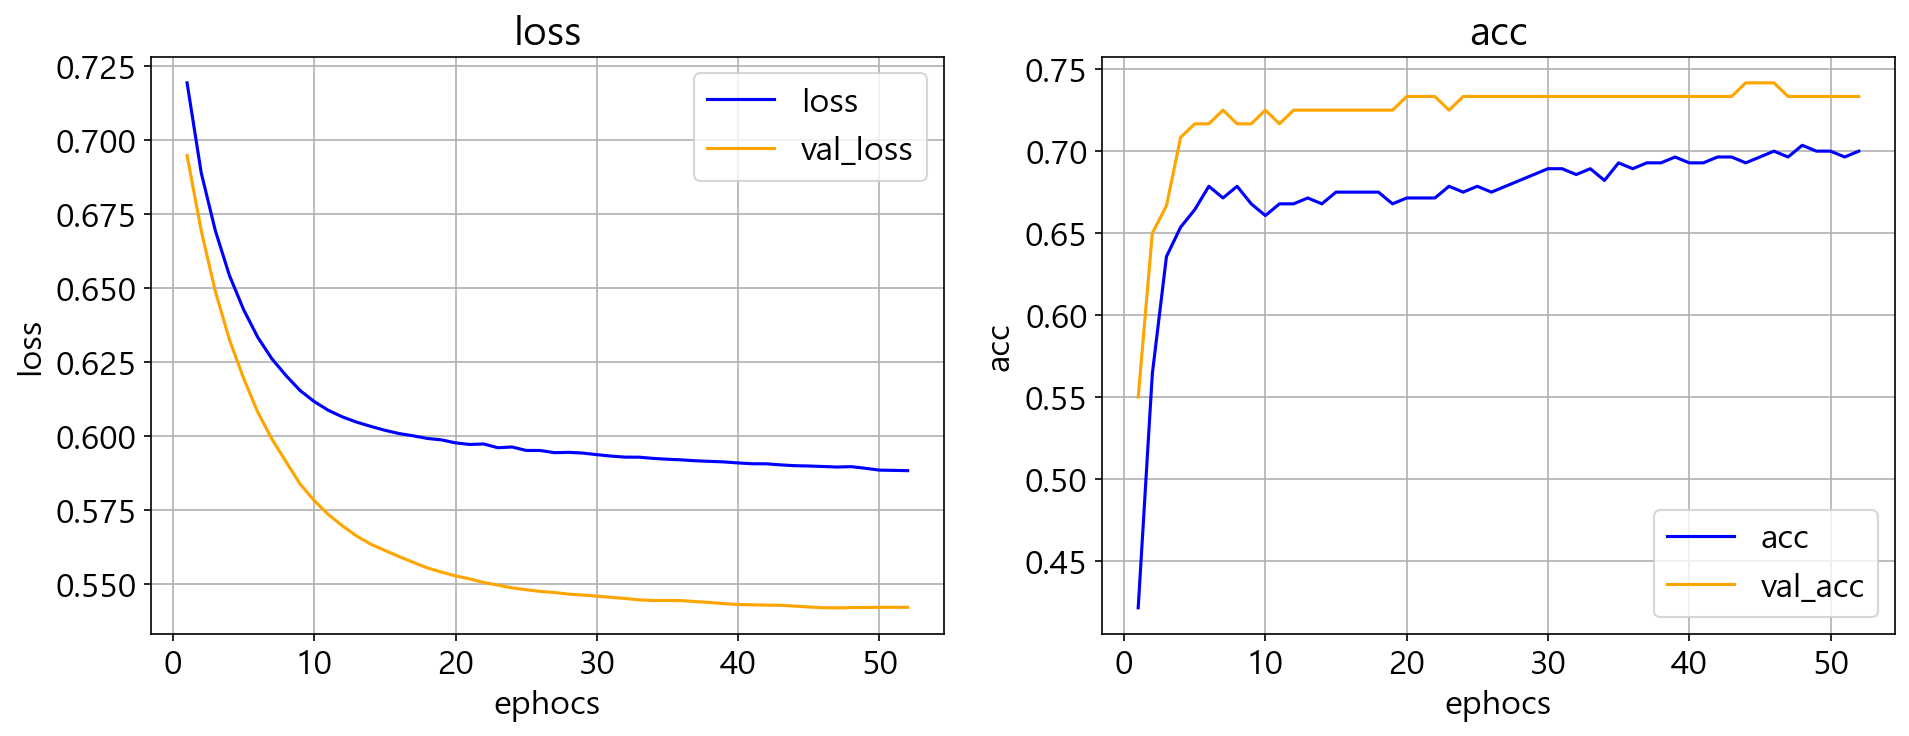

9/9 [==============================] - 0s 1ms/step - loss: 0.5878 - acc: 0.6964
최종 훈련 손실률: 0.587795, 최종 훈련 정확도: 0.696429
4/4 [==============================] - 0s 3ms/step - loss: 0.5422 - acc: 0.7333
최종 검증 손실률: 0.542196, 최종 검증 정확도: 0.733333


In [15]:
helper.tf_result_plot(result)

evaluate1 = model.evaluate(x_train, y_train)
print("최종 훈련 손실률: %f, 최종 훈련 정확도: %f" % (evaluate1[0], evaluate1[1]))

evaluate2 = model.evaluate(x_test, y_test)
print("최종 검증 손실률: %f, 최종 검증 정확도: %f" % (evaluate2[0], evaluate2[1]))

## #08. 학습 결과 적용

### 훈련 데이터에 대한 예측 결과 산정

In [17]:
train_pred = model.predict(x_train)
data_count, case_count = train_pred.shape
print("%d개의 훈련 데이터가 %d개의 경우의 수를 갖는다." % (data_count, case_count))
print(train_pred)

1/9 [==>...........................] - ETA: 0s

9/9 [==============================] - 0s 1ms/step
280개의 훈련 데이터가 1개의 경우의 수를 갖는다.
[[0.38554093]
 [0.51931155]
 [0.13864656]
 [0.2419784 ]
 [0.19153245]
 [0.13362187]
 [0.48184246]
 [0.49934697]
 [0.362153  ]
 [0.41089076]
 [0.3303688 ]
 [0.4293607 ]
 [0.44028932]
 [0.32314318]
 [0.17047554]
 [0.41127643]
 [0.23604397]
 [0.4654048 ]
 [0.5495999 ]
 [0.51532394]
 [0.38427538]
 [0.47824615]
 [0.3368628 ]
 [0.13068505]
 [0.35980323]
 [0.33280298]
 [0.40008608]
 [0.35501587]
 [0.4387945 ]
 [0.49010807]
 [0.3479687 ]
 [0.48957804]
 [0.35516596]
 [0.22181113]
 [0.4010152 ]
 [0.29020542]
 [0.18011667]
 [0.08990365]
 [0.37665305]
 [0.420658  ]
 [0.41790304]
 [0.14220761]
 [0.4367291 ]
 [0.3176258 ]
 [0.3148981 ]
 [0.4350925 ]
 [0.08425802]
 [0.28214034]
 [0.43267396]
 [0.14362486]
 [0.42351413]
 [0.35214335]
 [0.45076567]
 [0.14897004]
 [0.4737499 ]
 [0.52960235]
 [0.35832244]
 [0.42351413]
 [0.13581197]
 [0.3142334 ]
 [0.34985974]
 [0.41485518]
 [0.2400361 ]
 [0.35234338]
 [0.23816204]
 [0.24527

### 검증 데이터에 대한 예측 결과 산정

In [18]:
test_pred = model.predict(x_test)
data_count, case_count = test_pred.shape
print("%d개의 검증 데이터가 %d개의 경우의 수를 갖는다." % (data_count, case_count))
#print(test_pred)

4/4 [==============================] - 0s 6ms/step
120개의 검증 데이터가 1개의 경우의 수를 갖는다.


### 결과 데이터 셋 구성

In [19]:
kdf = DataFrame({
    '결과값': y_train['합격여부'].values,
    '예측치' : np.round(train_pred.flatten()),
    '합격확률(%)': np.round(train_pred.flatten() * 100, 1)
})

kdf

,결과값,예측치,합격확률(%)
0,1,0.0,38.599998
1,1,1.0,51.900002
2,1,0.0,13.900000
3,0,0.0,24.200001
4,0,0.0,19.200001
...,...,...,...
275,0,0.0,4.200000
276,0,0.0,44.799999
277,0,0.0,14.900000
278,1,0.0,47.400002


#### 혼동행렬

In [20]:
cm = confusion_matrix(kdf['결과값'], kdf['예측치'])
tn, fp, fn, tp = cm.ravel()
print(tn, fp, fn, tp)
cmdf1 = DataFrame([[tn, fn], [fp, tp]], index=['True', 'False'], columns=['Negative', 'Positive'])
cmdf1

183 6 79 12


,Negative,Positive
True,183,79
False,6,12


| | Negative|Positive|
|--|--|--|
| True | TN | FP |
| False | FN | TP |

#### 각 항목의 의미

| 구분 | 설명 |
|--|--|
| TN(True Negative, Negative Negative) | 실제는 Negative인데, Negative로 예측함. |
| FP(False Positive, Negative Positive) | 실제는 Negative인데, Positive로 예측함. (Type1 Error) |
| FN(False Negative, Positive Negative) | 실제는 Positive인데, Negative로 예측함. (Type2 Error) |
| TP(True Positive, Positive Positive) | 실제는 Positive인데, Positive로 예측함. |

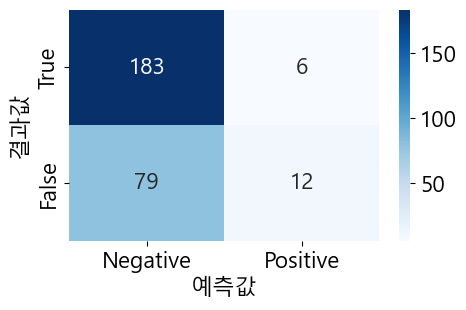

In [21]:
plt.figure(figsize=(5,3))
# 오차 행렬을 히트맵 그래프로 표현
# -> annot : 그래프의 각 칸에 수치값 출력
# -> fmt : 수치값 출력 format (여기서는 10진수)
# -> cmap : 색상맵 (<https://matplotlib.org/3.2.1/tutorials/colors/colormaps.html>)
sb.heatmap(cm, annot = True, fmt = 'd',cmap = 'Blues')
plt.xticks([0.5, 1.5], ['Negative', 'Positive'])
plt.yticks([0.5, 1.5], ['True', 'False'])
plt.xlabel('예측값')
plt.ylabel('결과값')
plt.show()

### 평가지표

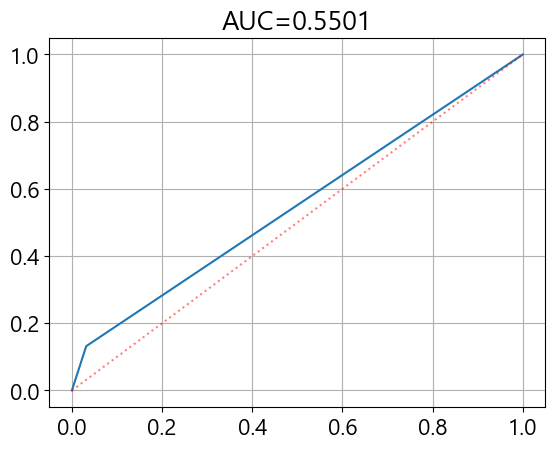

In [23]:
ras = roc_auc_score(kdf['결과값'], kdf['예측치'])

# 위양성율, 재현율, 임계값(사용안함)
fpr, tpr, thresholds = roc_curve(kdf['결과값'], kdf['예측치'])

plt.figure()
sb.lineplot(x=fpr, y=tpr)
sb.lineplot(x=[0,1], y=[0,1], color='red', linestyle=':', alpha=0.5)
plt.title('AUC={:.4f}'.format(ras))
plt.grid()
plt.show()
plt.close()

In [24]:
# 정확도
acc = accuracy_score(kdf['결과값'], kdf['예측치'])

# 정밀도
pre = precision_score(kdf['결과값'], kdf['예측치'])

# 재현율
recall = recall_score(kdf['결과값'], kdf['예측치'])

# F1 score
f1 = f1_score(kdf['결과값'], kdf['예측치'])

# 위양성율
fallout = fp / (fp + tn)

# 특이성
spe = 1 - fallout

result_df = DataFrame({'정확도(Accuracy)':[acc], '정밀도(Precision)':[pre], '재현율(Recall, TPR)':[recall], '위양성율(Fallout, FPR)': [fallout], '특이성(Specificity, TNR)':[spe], 'RAS': [ras], 'f1_score':[f1]})

helper.prettyPrint(result_df.T)

+--------------------------+----------+
|                          |        0 |
|--------------------------+----------|
| 정확도(Accuracy)         | 0.696429 |
| 정밀도(Precision)        | 0.666667 |
| 재현율(Recall, TPR)      | 0.131868 |
| 위양성율(Fallout, FPR)   | 0.031746 |
| 특이성(Specificity, TNR) | 0.968254 |
| RAS                      | 0.550061 |
| f1_score                 | 0.220183 |
+--------------------------+----------+


### 분류 보고서

- precision : 정밀도 (분류기가 참으로 분류한 항목 중에서 실제 데이터가 참인 비율)
- recall : 재현율 (실제 참 중에서 분류기가 참으로 분류한 비율)
- f1-score : 2*(Recall * Precision) / (Recall + Precision)
    - Precision과 Recall의 조화평균
    - 주로 분류 클래스 간 데이터가 심각한 불균형을 이루는 경우에 사용
    - 정확도의 경우, 클래스가 데이터 분류가 균일하지 못하면 머신의 성능을 제대로 나타내줄 수 없기 때문에 F1을 사용한다.
- support : 전체 데이터 수

In [28]:
report = classification_report(kdf['결과값'], kdf['예측치'])
print(report)

              precision    recall  f1-score   support

           0       0.70      0.97      0.81       189
           1       0.67      0.13      0.22        91

    accuracy                           0.70       280
   macro avg       0.68      0.55      0.52       280
weighted avg       0.69      0.70      0.62       280

